In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [4]:
!nvidia-smi

Thu Jul 28 06:21:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Functions

In [5]:
def loss_acc(model):

  fig , ax = plt.subplots(1,2)


  test_acc = model.history.history["val_accuracy"]
  test_loss = model.history.history["val_loss"]
  train_acc = model.history.history["accuracy"]
  train_loss = model.history.history["loss"]

  epochs = range(1, len(test_acc) + 1)

  fig.set_size_inches(20,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
  ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()


# Importing Train-Test Data

In [6]:
base_dir = "/content/drive/MyDrive/Emotion-Detection/mel_spectrogram"

train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Directory with training normal/abnormal spectrograms
train_angry    = os.path.join(train_dir, 'angry')
train_disgust  = os.path.join(train_dir, 'disgust')
train_fear     = os.path.join(train_dir, 'fear')
train_happy    = os.path.join(train_dir, 'happy')
train_neutral  = os.path.join(train_dir, 'neutral')
train_sad      = os.path.join(train_dir, 'sad')
train_surprise = os.path.join(train_dir, 'surprise')


# Directory with test normal/abnormal spectrograms

test_angry    = os.path.join(test_dir, 'angry')
test_disgust  = os.path.join(test_dir, 'disgust')
test_fear     = os.path.join(test_dir, 'fear')
test_happy    = os.path.join(test_dir, 'happy')
test_neutral  = os.path.join(test_dir, 'neutral')
test_sad      = os.path.join(test_dir, 'sad')
test_surprise = os.path.join(test_dir, 'surprise')


In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=30,
                                                    class_mode="categorical",
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = "categorical",
                                                         target_size = target_size)



Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


# First Model

In [ ]:
model_1 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 87616)             0         
                                                                 
 dense_36 (Dense)            (None, 64)                5607488   
                                                                 
 dense_37 (Dense)            (None, 7)                 455       
                                                                 
Total params: 5,608,391
Trainable params: 5,608,391
Non-trainable params: 0
___________________________________________

In [ ]:
model_1.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_1.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 96s 1s/step - loss: 0.7656 - accuracy: 0.8241 - val_loss: 0.0188 - val_accuracy: 0.9964
Epoch 2/10
75/75 [==============================] - 93s 1s/step - loss: 0.0078 - accuracy: 0.9991 - val_loss: 0.0135 - val_accuracy: 0.9964
Epoch 3/10
75/75 [==============================] - 97s 1s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9982
Epoch 4/10
75/75 [==============================] - 95s 1s/step - loss: 9.9839e-04 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9982
Epoch 5/10
75/75 [==============================] - 94s 1s/step - loss: 5.5638e-04 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9982
Epoch 6/10
75/75 [==============================] - 94s 1s/step - loss: 3.9558e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9982
Epoch 7/10
75/75 [==============================] - 94s 1s/step - loss: 3.0535e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9982
Epoc

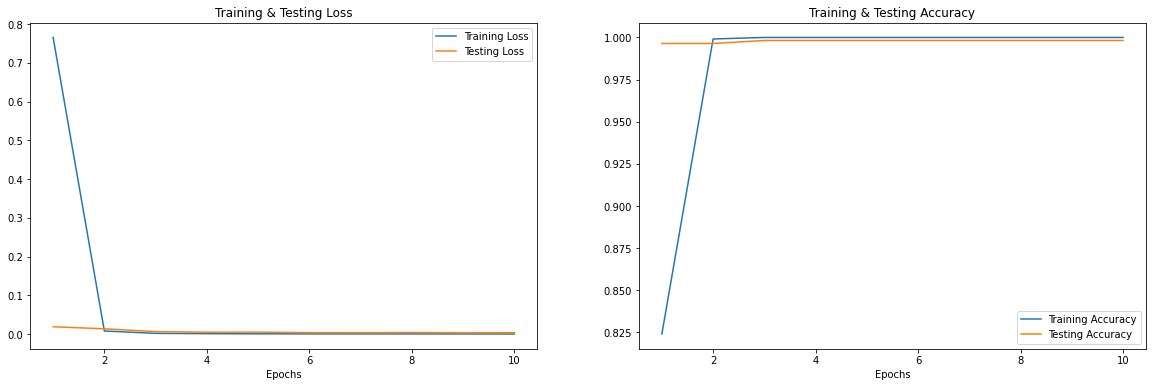

In [ ]:
loss_acc(model_1)

# Second Model

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=30,
                                                    class_mode="categorical",
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = "categorical",
                                                         target_size = target_size)

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')   
])
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 17, 17, 64)     

In [ ]:
model_2.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_2.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 95s 1s/step - loss: 0.7837 - accuracy: 0.7415 - val_loss: 0.0600 - val_accuracy: 0.9821
Epoch 2/10
75/75 [==============================] - 95s 1s/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0243 - val_accuracy: 0.9911
Epoch 3/10
75/75 [==============================] - 97s 1s/step - loss: 0.0083 - accuracy: 0.9969 - val_loss: 0.0270 - val_accuracy: 0.9893
Epoch 4/10
75/75 [==============================] - 96s 1s/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0240 - val_accuracy: 0.9929
Epoch 5/10
75/75 [==============================] - 96s 1s/step - loss: 8.4081e-04 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9982
Epoch 6/10
75/75 [==============================] - 96s 1s/step - loss: 8.2523e-05 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 0.9982
Epoch 7/10
75/75 [==============================] - 95s 1s/step - loss: 5.8467e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9982
Epoch 8/

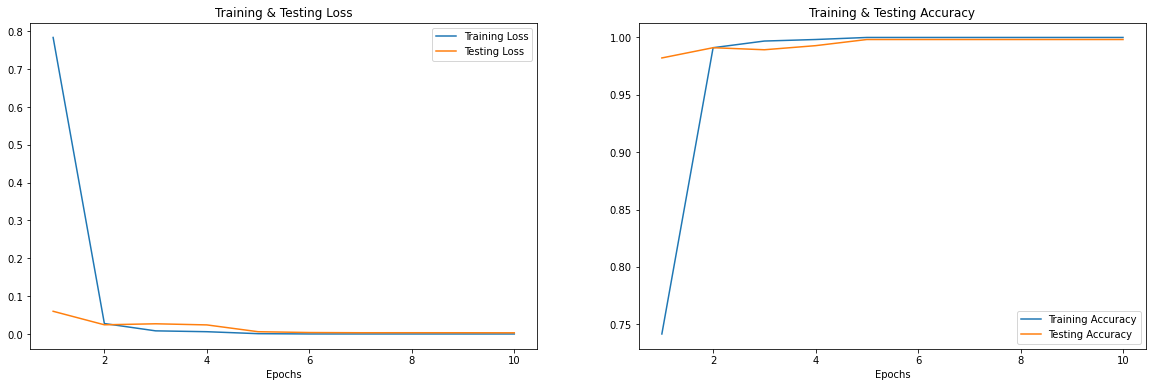

In [ ]:
loss_acc(model_2)

# Third Model


In [ ]:
model_3 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
model_3.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_3.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
75/75 [==============================] - 98s 1s/step - loss: 1.3414 - accuracy: 0.6089 - val_loss: 0.5181 - val_accuracy: 0.8982
Epoch 2/10
75/75 [==============================] - 98s 1s/step - loss: 0.2679 - accuracy: 0.9527 - val_loss: 0.1200 - val_accuracy: 0.9804
Epoch 3/10
75/75 [==============================] - 99s 1s/step - loss: 0.0874 - accuracy: 0.9835 - val_loss: 0.0748 - val_accuracy: 0.9839
Epoch 4/10
75/75 [==============================] - 99s 1s/step - loss: 0.0425 - accuracy: 0.9933 - val_loss: 0.0389 - val_accuracy: 0.9911
Epoch 5/10
75/75 [==============================] - 98s 1s/step - loss: 0.0247 - accuracy: 0.9982 - val_loss: 0.0402 - val_accuracy: 0.9839
Epoch 6/10
75/75 [==============================] - 96s 1s/step - loss: 0.0158 - accuracy: 0.9991 - val_loss: 0.0282 - val_accuracy: 0.9964
Epoch 7/10
75/75 [==============================] - 96s 1s/step - loss: 0.0096 - accuracy: 0.9996 - val_loss: 0.0195 - val_accuracy: 0.9929
Epoch 8/10
75/75 [==

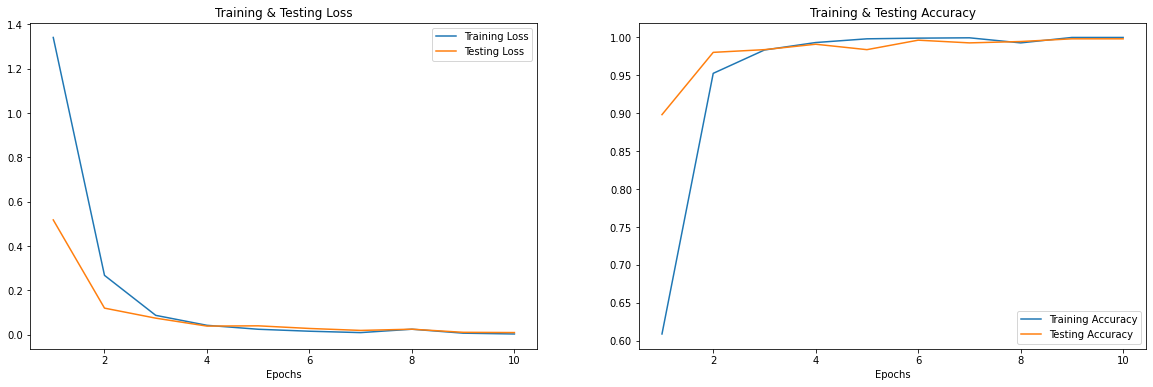

In [ ]:
loss_acc(model_3)

# Forth Model

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255, 
                                  #  rotation_range=30,
                                  #  width_shift_range=0.2,
                                  #  height_shift_range=0.2,
                                  #  shear_range=0.2,
                                  #  zoom_range=0.2,
                                  #  horizontal_flip=True,
                                   dtype= tf.float64)


test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=30,
                                                    class_mode="categorical",
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = "categorical",
                                                         target_size = target_size)



Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=2,
#     mode="min"
# )


model_4 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    # tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')  
])
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 41472)             0         
                                                                 
 dense_32 (Dense)            (None, 128)              

In [ ]:
model_4.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_4.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/15
75/75 [==============================] - 97s 1s/step - loss: 0.6970 - accuracy: 0.8228 - val_loss: 0.0247 - val_accuracy: 0.9982
Epoch 2/15
75/75 [==============================] - 94s 1s/step - loss: 0.0111 - accuracy: 0.9987 - val_loss: 0.0264 - val_accuracy: 0.9893
Epoch 3/15
75/75 [==============================] - 95s 1s/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 4/15
75/75 [==============================] - 95s 1s/step - loss: 4.7405e-04 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 5/15
75/75 [==============================] - 95s 1s/step - loss: 3.1395e-04 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/15
75/75 [==============================] - 95s 1s/step - loss: 2.3623e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 7/15
75/75 [==============================] - 96s 1s/step - loss: 1.8212e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoc

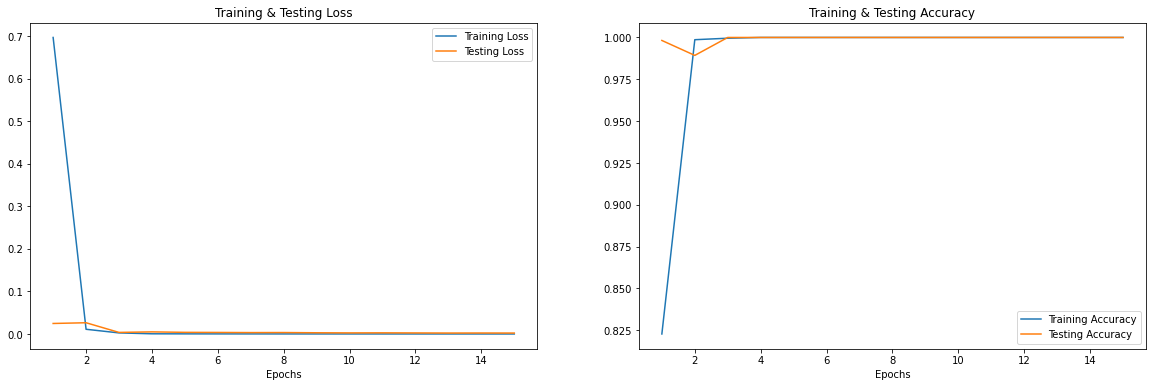

In [ ]:
loss_acc(model_4)

# Transfer Learning `EfficientNetB3`

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=50,
                                                    class_mode="categorical",
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=25,
                                                         class_mode  = "categorical",
                                                         target_size = target_size)



Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [ ]:
model_name='EfficientNetB3'
efficient_model=tf.keras.applications.EfficientNetB3(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=(target_size[0], target_size[1], 3),
                                      pooling='max') 

x=efficient_model.output

x=tf.keras.layers.BatchNormalization(axis=-1, 
                                  momentum=0.99,
                                  epsilon=0.001 )(x)

x = Dense(256, 
          kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
          activity_regularizer = tf.keras.regularizers.l1(0.05),
          bias_regularizer     = tf.keras.regularizers.l1(0.05),
          activation='relu')(x)
          
x=tf.keras.layers.Dropout(rate=.45, seed=123)(x)  

output=Dense(7, activation='softmax')(x)

eff_model=tf.keras.models.Model(inputs=efficient_model.input, outputs=output)

eff_model.compile(tf.keras.optimizers.Adamax(learning_rate=.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

# eff_model.summary()

In [ ]:
eff_model.fit(
            train_generator,
            epochs=25,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/25
45/45 [==============================] - 112s 2s/step - loss: 22.1103 - accuracy: 0.7415 - val_loss: 17.6656 - val_accuracy: 0.1429
Epoch 2/25
45/45 [==============================] - 94s 2s/step - loss: 13.3407 - accuracy: 0.9580 - val_loss: 12.4169 - val_accuracy: 0.1429
Epoch 3/25
45/45 [==============================] - 94s 2s/step - loss: 9.3593 - accuracy: 0.9781 - val_loss: 8.9780 - val_accuracy: 0.1429
Epoch 4/25
45/45 [==============================] - 97s 2s/step - loss: 6.6729 - accuracy: 0.9915 - val_loss: 6.7828 - val_accuracy: 0.1429
Epoch 5/25
45/45 [==============================] - 104s 2s/step - loss: 4.8382 - accuracy: 0.9960 - val_loss: 5.3822 - val_accuracy: 0.1429
Epoch 6/25
45/45 [==============================] - 102s 2s/step - loss: 3.5955 - accuracy: 0.9951 - val_loss: 4.4163 - val_accuracy: 0.1429
Epoch 7/25
45/45 [==============================] - 98s 2s/step - loss: 2.7382 - accuracy: 0.9978 - val_loss: 3.6858 - val_accuracy: 0.1571
Epoch 8/25
45

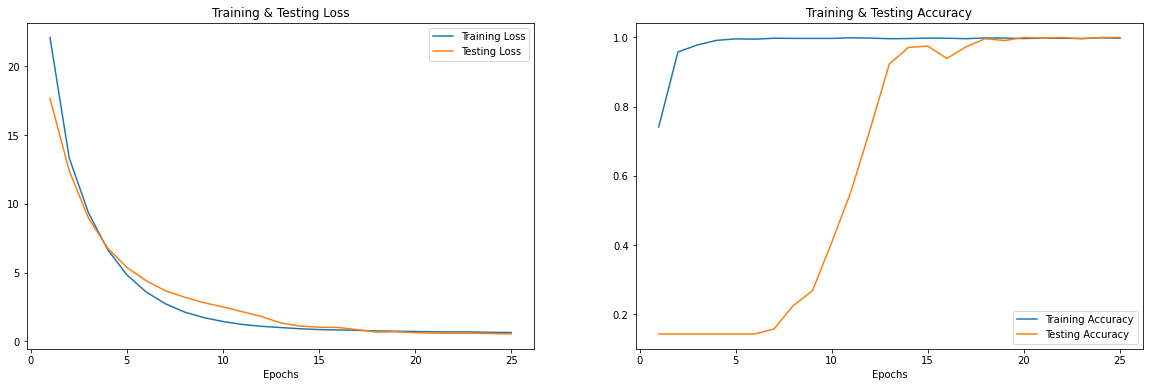

In [ ]:
loss_acc(eff_model)

# Transfer Learning `EfficientNetB7`


In [7]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 30
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



In [8]:
model_name='EfficientNetB7'

efficient_7=tf.keras.applications.EfficientNetB7(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=7,
                                      classifier_activation='softmax',
                                      pooling='max') 

efficient_7.summary()

258088960/258076736 [==============================] - 1s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Ze

In [9]:
def extract_features(directory, sample_amount, transfer, batch_size = 30, n_class = 7):
    features = np.zeros(shape=(sample_amount, 2560)) 
    labels = np.zeros(shape=(sample_amount, n_class))
    generator = datagen.flow_from_directory(
                                            directory, 
                                            target_size = target_size, 
                                            batch_size  = batch_size, 
                                            class_mode  ='categorical')
    # i=0
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = transfer.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [10]:
# You should be able to divide sample_amount by batch_size
train_features, train_labels = extract_features(train_dir, 2240, efficient_7) 
test_features, test_labels = extract_features(test_dir, 560, efficient_7)


# train_features = np.reshape(train_features, (540, 2 * 2 * 512))
# validation_features = np.reshape(validation_features, (200, 2 * 2 * 512))
# test_features = np.reshape(test_features, (180, 2 * 2 * 512))

# print(test_features.shape)

Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.
train_features:  (2240, 2560)
train_labels:  (2240, 7)


In [24]:
eff_model_7 = Sequential()
eff_model_7.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_7.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim=2560))
eff_model_7.add(Dropout(0.45))
eff_model_7.add(layers.Dense(256))
eff_model_7.add(Dropout(0.45))
eff_model_7.add(layers.Dense(128))
eff_model_7.add(Dropout(0.45))

eff_model_7.add(layers.Dense(7, activation='softmax'))

eff_model_7.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_7.fit(train_features, train_labels,
                    epochs=35,
                    batch_size=30,
                    validation_data=(test_features, test_labels))
print("Fitting Done")

Epoch 1/35
75/75 [==============================] - 2s 8ms/step - loss: 38.3365 - accuracy: 0.4442 - val_loss: 49.2902 - val_accuracy: 0.1429
Epoch 2/35
75/75 [==============================] - 0s 5ms/step - loss: 27.3988 - accuracy: 0.6384 - val_loss: 31.1480 - val_accuracy: 0.1429
Epoch 3/35
75/75 [==============================] - 0s 6ms/step - loss: 19.3691 - accuracy: 0.7147 - val_loss: 23.0242 - val_accuracy: 0.1429
Epoch 4/35
75/75 [==============================] - 0s 5ms/step - loss: 13.5342 - accuracy: 0.7701 - val_loss: 15.1376 - val_accuracy: 0.1429
Epoch 5/35
75/75 [==============================] - 0s 5ms/step - loss: 9.5700 - accuracy: 0.8219 - val_loss: 10.8307 - val_accuracy: 0.1429
Epoch 6/35
75/75 [==============================] - 0s 6ms/step - loss: 6.9127 - accuracy: 0.8469 - val_loss: 8.4061 - val_accuracy: 0.1482
Epoch 7/35
75/75 [==============================] - 1s 7ms/step - loss: 5.1907 - accuracy: 0.8647 - val_loss: 5.9000 - val_accuracy: 0.2625
Epoch 8/35


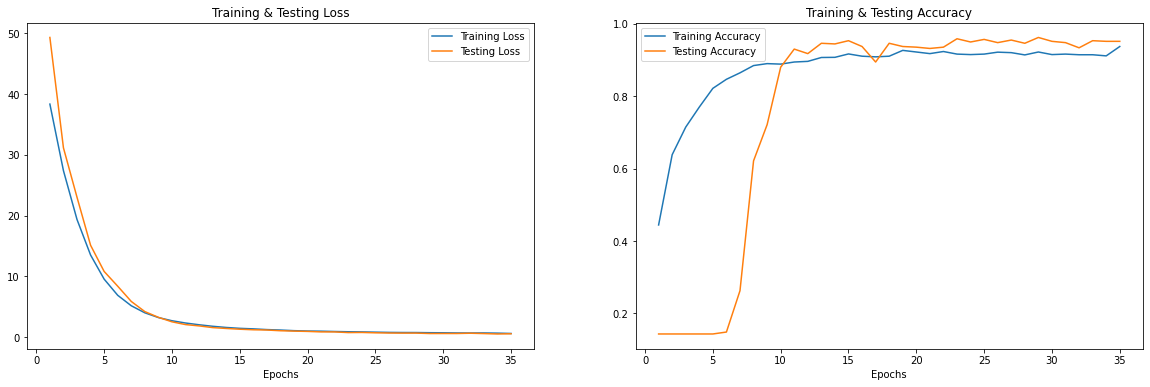

In [25]:
loss_acc(eff_model_7)